In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [4]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=164, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=132, shuffle=True
)

In [5]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['benign', 'malignant']


In [6]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ELU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ELU()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ELU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
        output=self.fc(output)            
        return output

In [7]:
model=ConvNet(num_classes=2).to(device)

In [8]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [10]:
num_epochs=100

In [11]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [12]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [14]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss = 0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss= test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_elu.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(4.0153) Train Accuracy: 0.7686765263557073 Test Accuracy: 0.7666666666666667
Epoch: 1 Train Loss: tensor(2.4808) Train Accuracy: 0.7876374668183542 Test Accuracy: 0.7363636363636363
Epoch: 2 Train Loss: tensor(2.9008) Train Accuracy: 0.7720894956389837 Test Accuracy: 0.75
Epoch: 3 Train Loss: tensor(3.4313) Train Accuracy: 0.7914296549108836 Test Accuracy: 0.7712121212121212
Epoch: 4 Train Loss: tensor(2.5352) Train Accuracy: 0.78839590443686 Test Accuracy: 0.7075757575757575
Epoch: 5 Train Loss: tensor(2.0391) Train Accuracy: 0.8065984072810012 Test Accuracy: 0.7757575757575758
Epoch: 6 Train Loss: tensor(1.4957) Train Accuracy: 0.8084945013272659 Test Accuracy: 0.7803030303030303
Epoch: 7 Train Loss: tensor(2.3253) Train Accuracy: 0.7974971558589306 Test Accuracy: 0.7727272727272727
Epoch: 8 Train Loss: tensor(2.1391) Train Accuracy: 0.8395904436860068 Test Accuracy: 0.7393939393939394
Epoch: 9 Train Loss: tensor(1.6625) Train Accuracy: 0.8399696624952597 

Epoch: 80 Train Loss: tensor(2.5400e-05) Train Accuracy: 1.0 Test Accuracy: 0.7787878787878788
Epoch: 81 Train Loss: tensor(2.8330e-05) Train Accuracy: 1.0 Test Accuracy: 0.7757575757575758
Epoch: 82 Train Loss: tensor(2.4874e-05) Train Accuracy: 1.0 Test Accuracy: 0.7833333333333333
Epoch: 83 Train Loss: tensor(2.5785e-05) Train Accuracy: 1.0 Test Accuracy: 0.7681818181818182
Epoch: 84 Train Loss: tensor(2.6871e-05) Train Accuracy: 1.0 Test Accuracy: 0.7712121212121212
Epoch: 85 Train Loss: tensor(3.3339e-05) Train Accuracy: 1.0 Test Accuracy: 0.7772727272727272
Epoch: 86 Train Loss: tensor(3.0664e-05) Train Accuracy: 1.0 Test Accuracy: 0.7696969696969697
Epoch: 87 Train Loss: tensor(2.5016e-05) Train Accuracy: 1.0 Test Accuracy: 0.7772727272727272
Epoch: 88 Train Loss: tensor(4.3302e-05) Train Accuracy: 1.0 Test Accuracy: 0.7803030303030303
Epoch: 89 Train Loss: tensor(0.0001) Train Accuracy: 1.0 Test Accuracy: 0.7681818181818182
Epoch: 90 Train Loss: tensor(0.0015) Train Accuracy: 0

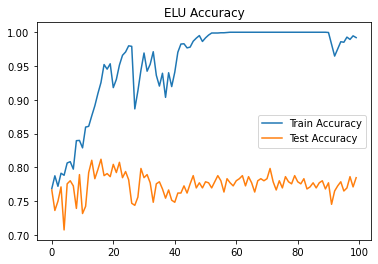

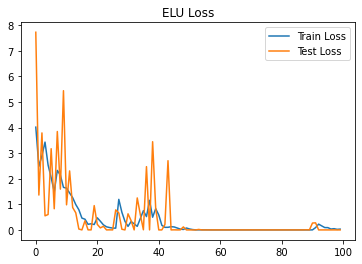

In [18]:
plt.title('ELU Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ELU Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [19]:
checkpoint = torch.load('best_checkpoint_elu.model')
model = ConvNet(num_classes=2)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:
import torchinfo

In [21]:
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─ELU: 1-3                               [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           2,180